In [1]:
import os
import mysql.connector
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

## Electricity price Prediction of 2014 -2019

In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor

In [3]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score,explained_variance_score

In [4]:
config = {
  'user': 'root',
  'password': 'root',
  'host': 'localhost',
  'database': 'electric_predict',
    'port':'3308',
    'auth_plugin':"mysql_native_password"
}

In [5]:
mysql_connection = mysql.connector.connect(**config)

In [6]:
market_data = pd.read_sql("SELECT * FROM `market$price$data_new`   WHERE MARKET_INDEX_DATA_PROVIDER != 'N2EXMIDP'  and MARKET_INDEX_PRICE > 0 and settlement_date BETWEEN '2014-01-01 00:00:00' AND '2019-12-31 00:00:00'", con=mysql_connection)

In [7]:
demand_data = pd.read_sql(" SELECT * FROM demanddata2 where SETTLEMENT_DATE BETWEEN '2014-01-01 00:00:00' AND '2019-12-31 00:00:00'", con=mysql_connection)

In [8]:
energy_source = pd.read_sql(" SELECT * FROM df_fuel_ckan where DATE_TIME Between '2014-01-01 00:00:00' AND '2019-12-31 00:00:00'", con=mysql_connection)

In [9]:
systemSell=pd.read_excel('D:\Project\SellBuyDataSet/SystemSell.xlsx')

In [10]:
sbp_start =pd.to_datetime('01-01-2014',infer_datetime_format=True)
sbp_end = pd.to_datetime('31-12-2019',infer_datetime_format=True)
#SSP2New = systemSell[(systemSell['Date'] >= sbp_start) & (systemSell['Date'] <= sbp_end)]

In [11]:
SSP2New = systemSell[(systemSell['Date'] >= sbp_start) & (systemSell['Date'] <= sbp_end)]

In [12]:
systemSella=SSP2New.drop(columns=['SSP Daily Average (£/Mwh)','Run'],axis=1)

In [13]:
SSPa= systemSella.melt(id_vars='Date',var_name= 'Settlement_Period',value_name='System Sell Price')

sell_data = SSPa.sort_values(by=['Date', 'Settlement_Period']).reset_index(drop=True)

In [14]:
print(len(market_data),len(demand_data),len(energy_source), len(sell_data))

104746 105168 105120 105168


In [15]:
market_data

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,MARKET_INDEX_DATA_PROVIDER,MARKET_INDEX_VOLUME,MARKET_INDEX_PRICE
0,2014-01-01,1,APXMIDP,302,35
1,2014-01-01,2,APXMIDP,366,37
2,2014-01-01,3,APXMIDP,184,42
3,2014-01-01,4,APXMIDP,185,37
4,2014-01-01,5,APXMIDP,284,32
...,...,...,...,...,...
104741,2019-12-31,44,APXMIDP,1235,36
104742,2019-12-31,45,APXMIDP,1591,38
104743,2019-12-31,46,APXMIDP,1506,33
104744,2019-12-31,47,APXMIDP,1226,24


In [16]:
demand_data

,SETTLEMENT_DATE,SETTLEMENT_PERIOD,ND,TSD,ENGLAND_WALES_DEMAND,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,NON_BM_STOR,PUMP_STORAGE_PUMPING,IFA_FLOW,IFA2_FLOW,BRITNED_FLOW,MOYLE_FLOW,EAST_WEST_FLOW,NEMO_FLOW,NSL_FLOW,ELECLINK_FLOW
0,2014-01-01,1,30008,31920,27048,1084,2434,0,3349,0,870,1990,0,1000,-157,-285,0,NaN,NaN
1,2014-01-01,2,30589,32491,27625,1079,2434,0,3349,0,860,1990,0,1000,-157,-285,0,NaN,NaN
2,2014-01-01,3,30306,32521,27361,1079,2434,0,3349,0,1173,1990,0,1000,-157,-285,0,NaN,NaN
3,2014-01-01,4,29280,31735,26447,931,2434,0,3349,0,1413,1992,0,1000,-157,-285,0,NaN,NaN
4,2014-01-01,5,28174,30661,25461,931,2434,0,3349,0,1417,1748,0,880,-157,-313,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105163,2019-12-31,44,29318,30800,26609,1501,6465,0,13080,0,11,1999,0,1053,-349,-522,975,0.0,0.0
105164,2019-12-31,45,28260,29626,25618,1465,6465,0,13080,0,10,2000,0,493,-335,-421,84,0.0,0.0
105165,2019-12-31,46,27530,28817,24829,1429,6465,0,13080,0,10,1999,0,463,-263,-414,42,0.0,0.0
105166,2019-12-31,47,26765,27941,24093,1365,6465,0,13080,0,15,1715,0,836,-213,-348,809,0.0,0.0


In [17]:
energy_source

,DATE_TIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2014-01-01 00:00:00+00,2717,12104,8325,4469,768,2990,0,654,0,...,2.4,9.3,0,2,0,0,100,42.3,42.3,16.4
1,2014-01-01 00:30:00+00,2755,12545,8327,4601,767,2990,0,655,0,...,2.3,9.2,0,2,0,0,100,42,42,16.4
2,2014-01-01 01:00:00+00,2752,12561,8327,4686,708,2990,0,655,0,...,2.2,9.1,0,2,0,0,100,42,42,16.5
3,2014-01-01 01:30:00+00,2430,11961,8328,4774,716,2990,0,654,0,...,2.2,9.4,0,2.1,0,0,100,43.4,43.4,17.2
4,2014-01-01 02:00:00+00,2181,11846,8326,4670,702,2624,0,655,0,...,2.3,8.5,0,2.1,0,0,100,44.2,44.2,17.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,2019-12-30 21:30:00+00,12731,1054,6950,4886,804,4058,2945,124,0,...,2.4,12.1,8.8,0.4,0,0,100,46.4,37.7,17
105116,2019-12-30 22:00:00+00,11667,931,6950,4711,800,3988,2850,126,0,...,2.5,12.4,8.9,0.4,0,0.2,100,47.7,38.8,17.2
105117,2019-12-30 22:30:00+00,10749,670,6936,4614,839,3986,2936,128,0,...,2.7,12.9,9.5,0.4,0,0,100,49.7,40.1,17.7
105118,2019-12-30 23:00:00+00,9548,668,6942,4583,822,3612,2933,131,0,...,2.8,12.3,10,0.4,0,0.1,100,52.2,42.2,18.5


In [18]:
sell_data

,Date,Settlement_Period,System Sell Price
0,2014-01-01,1,35.32
1,2014-01-01,2,37.28
2,2014-01-01,3,41.50
3,2014-01-01,4,36.74
4,2014-01-01,5,28.66
...,...,...,...
105163,2019-12-31,44,52.50
105164,2019-12-31,45,52.00
105165,2019-12-31,46,11.15
105166,2019-12-31,47,12.00


In [19]:
energy_source['DATE_TIME']=pd.to_datetime(energy_source['DATE_TIME'])

In [20]:
# Remove the timezone information from the datetime column
energy_source['DATE_TIME'] = energy_source['DATE_TIME'].dt.tz_localize(None)

In [21]:
energy_source

,DATE_TIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2014-01-01 00:00:00,2717,12104,8325,4469,768,2990,0,654,0,...,2.4,9.3,0,2,0,0,100,42.3,42.3,16.4
1,2014-01-01 00:30:00,2755,12545,8327,4601,767,2990,0,655,0,...,2.3,9.2,0,2,0,0,100,42,42,16.4
2,2014-01-01 01:00:00,2752,12561,8327,4686,708,2990,0,655,0,...,2.2,9.1,0,2,0,0,100,42,42,16.5
3,2014-01-01 01:30:00,2430,11961,8328,4774,716,2990,0,654,0,...,2.2,9.4,0,2.1,0,0,100,43.4,43.4,17.2
4,2014-01-01 02:00:00,2181,11846,8326,4670,702,2624,0,655,0,...,2.3,8.5,0,2.1,0,0,100,44.2,44.2,17.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,2019-12-30 21:30:00,12731,1054,6950,4886,804,4058,2945,124,0,...,2.4,12.1,8.8,0.4,0,0,100,46.4,37.7,17
105116,2019-12-30 22:00:00,11667,931,6950,4711,800,3988,2850,126,0,...,2.5,12.4,8.9,0.4,0,0.2,100,47.7,38.8,17.2
105117,2019-12-30 22:30:00,10749,670,6936,4614,839,3986,2936,128,0,...,2.7,12.9,9.5,0.4,0,0,100,49.7,40.1,17.7
105118,2019-12-30 23:00:00,9548,668,6942,4583,822,3612,2933,131,0,...,2.8,12.3,10,0.4,0,0.1,100,52.2,42.2,18.5


In [22]:
demand_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105168 entries, 0 to 105167
Data columns (total 19 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   SETTLEMENT_DATE            105168 non-null  datetime64[ns]
 1   SETTLEMENT_PERIOD          105168 non-null  int64         
 2   ND                         105168 non-null  int64         
 3   TSD                        105168 non-null  int64         
 4   ENGLAND_WALES_DEMAND       105168 non-null  int64         
 5   EMBEDDED_WIND_GENERATION   105168 non-null  int64         
 6   EMBEDDED_WIND_CAPACITY     105168 non-null  int64         
 7   EMBEDDED_SOLAR_GENERATION  105168 non-null  int64         
 8   EMBEDDED_SOLAR_CAPACITY    105168 non-null  int64         
 9   NON_BM_STOR                105168 non-null  int64         
 10  PUMP_STORAGE_PUMPING       105168 non-null  int64         
 11  IFA_FLOW                   105168 non-null  int64   

In [23]:
demand_data['SETTLEMENT_DATE']=demand_data['SETTLEMENT_DATE'].astype(str)
demand_data['SETTLEMENT_PERIOD']=pd.to_numeric(demand_data['SETTLEMENT_PERIOD'],errors='coerce').astype('Int64')

In [24]:
from datetime import datetime
demand_data['date']=demand_data['SETTLEMENT_DATE'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
demand_data['Time Interval'] = (demand_data['SETTLEMENT_PERIOD']-1) * 30

In [25]:


demand_data['date'] = demand_data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
import datetime
demand_data['Time Format'] = demand_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [26]:
demand_data['Time Format'] = demand_data['Time Format'].apply(lambda x: x.strftime('%H:%M:%S'))
demand_data['DATETIME'] = pd.to_datetime(demand_data['date'] + ' ' + demand_data['Time Format'])
demand_data['Time Format'] = demand_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [27]:
demand_data2 =demand_data.groupby('DATETIME').agg({'SETTLEMENT_PERIOD': 'first',
                                                   'TSD': 'sum', 
                                                   'EMBEDDED_WIND_GENERATION': 'sum',
                                                   'EMBEDDED_WIND_CAPACITY': 'sum',  
                                                   'EMBEDDED_SOLAR_GENERATION': 'sum',  
                                                   'EMBEDDED_SOLAR_CAPACITY': 'sum',  
                                                   'ND': 'sum'}).reset_index()

In [28]:
demand_data2

,DATETIME,SETTLEMENT_PERIOD,TSD,EMBEDDED_WIND_GENERATION,EMBEDDED_WIND_CAPACITY,EMBEDDED_SOLAR_GENERATION,EMBEDDED_SOLAR_CAPACITY,ND
0,2014-01-01 00:00:00,1,31920,1084,2434,0,3349,30008
1,2014-01-01 00:30:00,2,32491,1079,2434,0,3349,30589
2,2014-01-01 01:00:00,3,32521,1079,2434,0,3349,30306
3,2014-01-01 01:30:00,4,31735,931,2434,0,3349,29280
4,2014-01-01 02:00:00,5,30661,931,2434,0,3349,28174
...,...,...,...,...,...,...,...,...
105151,2019-12-31 21:30:00,44,30800,1501,6465,0,13080,29318
105152,2019-12-31 22:00:00,45,29626,1465,6465,0,13080,28260
105153,2019-12-31 22:30:00,46,28817,1429,6465,0,13080,27530
105154,2019-12-31 23:00:00,47,27941,1365,6465,0,13080,26765


In [29]:
market_data['SETTLEMENT_DATE']=market_data['SETTLEMENT_DATE'].astype(str)
market_data['SETTLEMENT_PERIOD']=pd.to_numeric(market_data['SETTLEMENT_PERIOD'],errors='coerce').astype('Int64')

In [30]:
from datetime import datetime
market_data['date']=market_data['SETTLEMENT_DATE'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
market_data['Time Interval'] = (market_data['SETTLEMENT_PERIOD']-1) * 30

In [31]:

market_data['date'] =pd.to_datetime(market_data['date'])

In [32]:


market_data['date'] = market_data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
import datetime
market_data['Time Format'] = market_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [33]:
market_data['Time Format'] = market_data['Time Format'].apply(lambda x: x.strftime('%H:%M:%S'))
market_data['DATETIME'] = pd.to_datetime(market_data['date'] + ' ' + market_data['Time Format'])
market_data['Time Format'] = market_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [34]:
market_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104746 entries, 0 to 104745
Data columns (total 9 columns):
 #   Column                      Non-Null Count   Dtype         
---  ------                      --------------   -----         
 0   SETTLEMENT_DATE             104746 non-null  object        
 1   SETTLEMENT_PERIOD           104746 non-null  Int64         
 2   MARKET_INDEX_DATA_PROVIDER  104746 non-null  object        
 3   MARKET_INDEX_VOLUME         104746 non-null  int64         
 4   MARKET_INDEX_PRICE          104746 non-null  int64         
 5   date                        104746 non-null  object        
 6   Time Interval               104746 non-null  Int64         
 7   Time Format                 104746 non-null  object        
 8   DATETIME                    104746 non-null  datetime64[ns]
dtypes: Int64(2), datetime64[ns](1), int64(2), object(4)
memory usage: 7.4+ MB


In [35]:
market_data2 =market_data.groupby('DATETIME').agg({'SETTLEMENT_PERIOD': 'first',
                                                   'MARKET_INDEX_VOLUME': 'sum', 
                                                   'MARKET_INDEX_PRICE': 'sum',
                                                   }).reset_index()

In [36]:
market_data2

,DATETIME,SETTLEMENT_PERIOD,MARKET_INDEX_VOLUME,MARKET_INDEX_PRICE
0,2014-01-01 00:00:00,1,302,35
1,2014-01-01 00:30:00,2,366,37
2,2014-01-01 01:00:00,3,184,42
3,2014-01-01 01:30:00,4,185,37
4,2014-01-01 02:00:00,5,284,32
...,...,...,...,...
104730,2019-12-31 21:30:00,44,1235,36
104731,2019-12-31 22:00:00,45,1591,38
104732,2019-12-31 22:30:00,46,1506,33
104733,2019-12-31 23:00:00,47,1226,24


In [37]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105168 entries, 0 to 105167
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               105168 non-null  datetime64[ns]
 1   Settlement_Period  105168 non-null  object        
 2   System Sell Price  105156 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.4+ MB


In [38]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105168 entries, 0 to 105167
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               105168 non-null  datetime64[ns]
 1   Settlement_Period  105168 non-null  object        
 2   System Sell Price  105156 non-null  float64       
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 2.4+ MB


In [39]:
sell_data['Date']=sell_data['Date'].astype(str)
sell_data['Settlement_Period']=pd.to_numeric(sell_data['Settlement_Period'],errors='coerce').astype('Int64')

In [40]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105168 entries, 0 to 105167
Data columns (total 3 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   Date               105168 non-null  object 
 1   Settlement_Period  105168 non-null  Int64  
 2   System Sell Price  105156 non-null  float64
dtypes: Int64(1), float64(1), object(1)
memory usage: 2.5+ MB


In [41]:
#sell_data['Date'] =pd.to_datetime(sell_data['Date'])

In [42]:
from datetime import datetime
sell_data['date']=sell_data['Date'].apply(lambda x: datetime.strptime(x,'%Y-%m-%d'))
sell_data['Time Interval'] = (sell_data['Settlement_Period']-1) * 30

sell_data['date'] = sell_data['date'].dt.strftime('%Y-%m-%d %H:%M:%S')
import datetime
sell_data['Time Format'] = sell_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [43]:
sell_data['Time Format'] = sell_data['Time Format'].apply(lambda x: x.strftime('%H:%M:%S'))
sell_data['DATETIME'] = pd.to_datetime(market_data['date'] + ' ' + sell_data['Time Format'])
sell_data['Time Format'] = sell_data['Time Interval'].apply(lambda x:(datetime.datetime.min + datetime.timedelta(minutes=x)).time())

In [44]:
sell_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 105168 entries, 0 to 105167
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   Date               105168 non-null  object        
 1   Settlement_Period  105168 non-null  Int64         
 2   System Sell Price  105156 non-null  float64       
 3   date               105168 non-null  object        
 4   Time Interval      105168 non-null  Int64         
 5   Time Format        105168 non-null  object        
 6   DATETIME           104746 non-null  datetime64[ns]
dtypes: Int64(2), datetime64[ns](1), float64(1), object(3)
memory usage: 5.8+ MB


In [45]:
sell_data2 = sell_data.groupby('DATETIME').agg({'Settlement_Period': 'first',
                                                   'System Sell Price': 'sum', 
                                                  }).reset_index()

In [46]:
sell_data2

,DATETIME,Settlement_Period,System Sell Price
0,2014-01-01 00:00:00,1,35.32
1,2014-01-01 00:30:00,2,37.28
2,2014-01-01 01:00:00,3,41.50
3,2014-01-01 01:30:00,4,36.74
4,2014-01-01 02:00:00,5,28.66
...,...,...,...
104733,2019-12-31 21:30:00,44,53.90
104734,2019-12-31 22:00:00,45,52.00
104735,2019-12-31 22:30:00,46,52.00
104736,2019-12-31 23:00:00,47,51.50


In [47]:
predict_df1 = pd.merge(sell_data2, market_data2, on='DATETIME', how='inner')

In [48]:
len(predict_df1)

104405

In [49]:
energy_source

,DATE_TIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2014-01-01 00:00:00,2717,12104,8325,4469,768,2990,0,654,0,...,2.4,9.3,0,2,0,0,100,42.3,42.3,16.4
1,2014-01-01 00:30:00,2755,12545,8327,4601,767,2990,0,655,0,...,2.3,9.2,0,2,0,0,100,42,42,16.4
2,2014-01-01 01:00:00,2752,12561,8327,4686,708,2990,0,655,0,...,2.2,9.1,0,2,0,0,100,42,42,16.5
3,2014-01-01 01:30:00,2430,11961,8328,4774,716,2990,0,654,0,...,2.2,9.4,0,2.1,0,0,100,43.4,43.4,17.2
4,2014-01-01 02:00:00,2181,11846,8326,4670,702,2624,0,655,0,...,2.3,8.5,0,2.1,0,0,100,44.2,44.2,17.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,2019-12-30 21:30:00,12731,1054,6950,4886,804,4058,2945,124,0,...,2.4,12.1,8.8,0.4,0,0,100,46.4,37.7,17
105116,2019-12-30 22:00:00,11667,931,6950,4711,800,3988,2850,126,0,...,2.5,12.4,8.9,0.4,0,0.2,100,47.7,38.8,17.2
105117,2019-12-30 22:30:00,10749,670,6936,4614,839,3986,2936,128,0,...,2.7,12.9,9.5,0.4,0,0,100,49.7,40.1,17.7
105118,2019-12-30 23:00:00,9548,668,6942,4583,822,3612,2933,131,0,...,2.8,12.3,10,0.4,0,0.1,100,52.2,42.2,18.5


In [50]:
energy_source.rename(columns={'DATE_TIME':'DATETIME'},inplace=True)

In [51]:
energy_source

,DATETIME,GAS,COAL,NUCLEAR,WIND,HYDRO,BIOMASS,OTHER,SOLAR,STORAGE,...,IMPORTS_perc,BIOMASS_perc,OTHER_perc,SOLAR_perc,STORAGE_perc,GENERATION_perc,LOW_CARBON_perc,ZERO_CARBON_perc,RENEWABLE_perc,FOSSIL_perc
0,2014-01-01 00:00:00,2717,12104,8325,4469,768,2990,0,654,0,...,2.4,9.3,0,2,0,0,100,42.3,42.3,16.4
1,2014-01-01 00:30:00,2755,12545,8327,4601,767,2990,0,655,0,...,2.3,9.2,0,2,0,0,100,42,42,16.4
2,2014-01-01 01:00:00,2752,12561,8327,4686,708,2990,0,655,0,...,2.2,9.1,0,2,0,0,100,42,42,16.5
3,2014-01-01 01:30:00,2430,11961,8328,4774,716,2990,0,654,0,...,2.2,9.4,0,2.1,0,0,100,43.4,43.4,17.2
4,2014-01-01 02:00:00,2181,11846,8326,4670,702,2624,0,655,0,...,2.3,8.5,0,2.1,0,0,100,44.2,44.2,17.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
105115,2019-12-30 21:30:00,12731,1054,6950,4886,804,4058,2945,124,0,...,2.4,12.1,8.8,0.4,0,0,100,46.4,37.7,17
105116,2019-12-30 22:00:00,11667,931,6950,4711,800,3988,2850,126,0,...,2.5,12.4,8.9,0.4,0,0.2,100,47.7,38.8,17.2
105117,2019-12-30 22:30:00,10749,670,6936,4614,839,3986,2936,128,0,...,2.7,12.9,9.5,0.4,0,0,100,49.7,40.1,17.7
105118,2019-12-30 23:00:00,9548,668,6942,4583,822,3612,2933,131,0,...,2.8,12.3,10,0.4,0,0.1,100,52.2,42.2,18.5


In [52]:
predict_df2 = pd.merge(energy_source, demand_data2, on='DATETIME', how='inner')

In [53]:
len(predict_df2)

105108

In [54]:
predict_final = pd.merge(predict_df1, predict_df2, on='DATETIME', how='inner')

In [55]:
len(predict_final)

104357

## Correlation Between Sell Price, Market Index Values and Demand Data

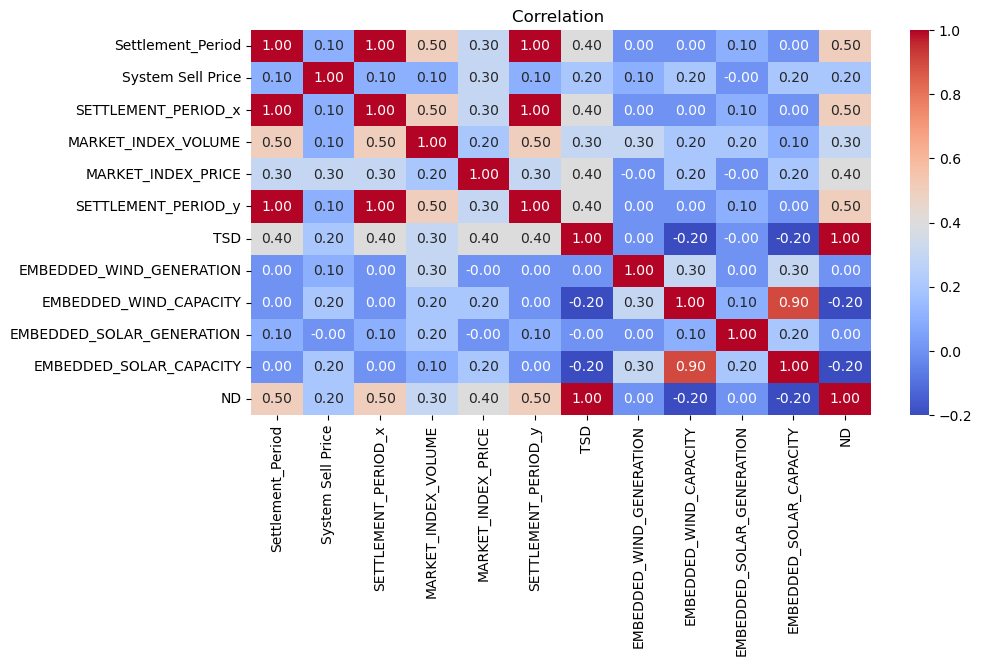

In [56]:
correlation_matrix = predict_final.corr()
#  heatmap correlation
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix.round(1), annot=True, cmap="coolwarm",fmt=".2f")
plt.title('Correlation ')
plt.show()

In [57]:
predict_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104357 entries, 0 to 104356
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   DATETIME                   104357 non-null  datetime64[ns]
 1   Settlement_Period          104357 non-null  Int64         
 2   System Sell Price          104357 non-null  float64       
 3   SETTLEMENT_PERIOD_x        104357 non-null  Int64         
 4   MARKET_INDEX_VOLUME        104357 non-null  int64         
 5   MARKET_INDEX_PRICE         104357 non-null  int64         
 6   GAS                        104357 non-null  object        
 7   COAL                       104357 non-null  object        
 8   NUCLEAR                    104357 non-null  object        
 9   WIND                       104357 non-null  object        
 10  HYDRO                      104357 non-null  object        
 11  BIOMASS                    104357 non-null  object  

In [58]:
predict_final['HYDRO_perc']=predict_final['HYDRO_perc'].astype(float)
predict_final['WIND_perc']=predict_final['WIND_perc'].astype(float)
predict_final['SOLAR_perc']=predict_final['SOLAR_perc'].astype(float)

In [59]:
predict_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 104357 entries, 0 to 104356
Data columns (total 43 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   DATETIME                   104357 non-null  datetime64[ns]
 1   Settlement_Period          104357 non-null  Int64         
 2   System Sell Price          104357 non-null  float64       
 3   SETTLEMENT_PERIOD_x        104357 non-null  Int64         
 4   MARKET_INDEX_VOLUME        104357 non-null  int64         
 5   MARKET_INDEX_PRICE         104357 non-null  int64         
 6   GAS                        104357 non-null  object        
 7   COAL                       104357 non-null  object        
 8   NUCLEAR                    104357 non-null  object        
 9   WIND                       104357 non-null  object        
 10  HYDRO                      104357 non-null  object        
 11  BIOMASS                    104357 non-null  object  

In [60]:
y = predict_final['MARKET_INDEX_PRICE'].copy()
X = predict_final[['MARKET_INDEX_VOLUME','TSD','System Sell Price','EMBEDDED_WIND_GENERATION','EMBEDDED_WIND_CAPACITY','HYDRO_perc','WIND_perc','SOLAR_perc']]

## Correlation between Independent Variable

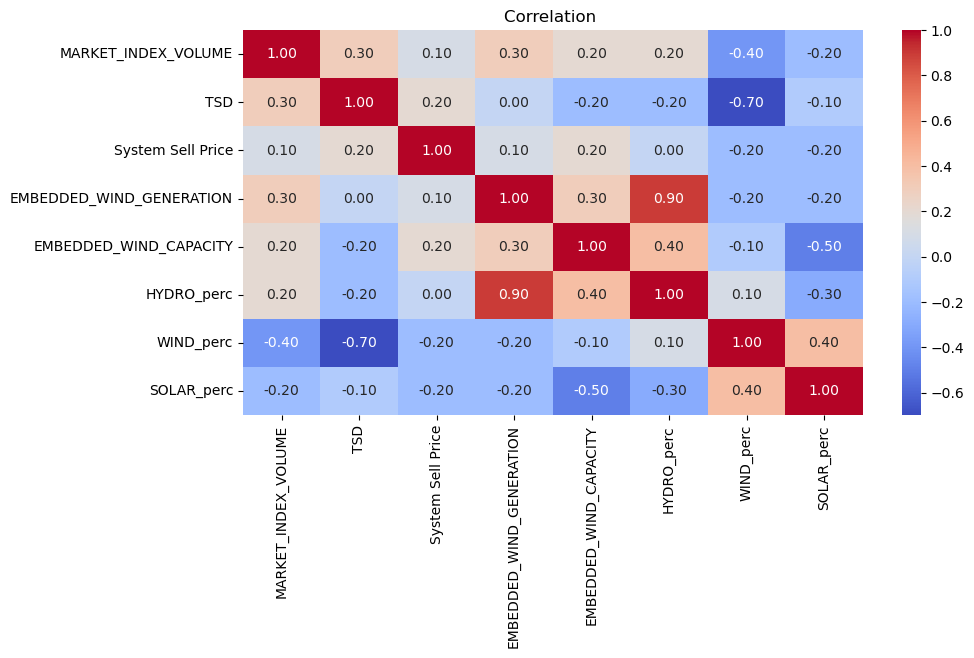

In [61]:
correlation_matrix = X.corr()

#  heatmap correlation
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix.round(1), annot=True, cmap="coolwarm",fmt=".2f")
plt.title('Correlation ')
plt.show()

## Linear Regression  to predict Electricity price of 2014 -2019 

In [62]:
sc = StandardScaler()

In [63]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 4)

In [64]:
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [65]:
mlr = LinearRegression()  
mlr.fit(X_train, y_train)

LinearRegression()

In [66]:
y_pred_mlr= mlr.predict(X_test)

In [67]:
print("r2 score: %.10f" % r2_score(y_test, y_pred_mlr))
print("explained variance score: %.10f" % explained_variance_score(y_test, y_pred_mlr))
print("mae: %.10f" % mean_absolute_error(y_test, y_pred_mlr))
print("mse: %.10f" % mean_squared_error(y_test, y_pred_mlr))
print("rmse: %.10f" % mean_squared_error(y_test, y_pred_mlr,squared = False))

r2 score: 0.3381221200
explained variance score: 0.3382079797
mae: 7.6804390573
mse: 180.8845862384
rmse: 13.4493340444


## Random Forest Regression model Predection

In [172]:
r2_lr=r2_score(y_test, y_pred_mlr)
mae_lr= mean_absolute_error(y_test, y_pred_mlr)
mse_lr= mean_squared_error(y_test, y_pred_mlr)
rmse_lr=mean_squared_error(y_test, y_pred_mlr,squared = False)

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Create the Random Forest regression model
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

In [135]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [132]:
rf_model.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

In [136]:
y_pred_rf = rf_model.predict(X_test)

In [137]:
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf= mean_absolute_error(y_test, y_pred_rf)
#mse_rf= mean_squared_error(y_test, y_pred_rf)
rmse_rf=mean_squared_error(y_test, y_pred_rf,squared = False)

r2_rf = r2_score(y_test, y_pred_rf)

In [138]:
print("r2 score: %.10f" % r2_score(y_test, y_pred))
print("explained variance score: %.10f" % explained_variance_score(y_test, y_pred))
print("mae: %.10f" % mean_absolute_error(y_test, y_pred))
print("mse: %.10f" % mean_squared_error(y_test, y_pred))
print("rmse: %.10f" % mean_squared_error(y_test, y_pred,squared = False))

r2 score: 0.8150177895
explained variance score: 0.8150533043
mae: 3.7195745496
mse: 54.4561107321
rmse: 7.3794383751


In [228]:
print("r2 score: %.10f" % r2_score(y_test, y_pred_rf))
print("explained variance score: %.10f" % explained_variance_score(y_test, y_pred_rf))
print("mae: %.10f" % mean_absolute_error(y_test, y_pred_rf))
print("mse: %.10f" % mean_squared_error(y_test, y_pred_rf))
print("rmse: %.10f" % mean_squared_error(y_test, y_pred_rf,squared = False))

r2 score: 0.8150177895
explained variance score: 0.8150533043
mae: 3.7195745496
mse: 54.4561107321
rmse: 7.3794383751


In [180]:
data_rf = y_pred_rf.reshape(-1)

In [182]:
rf_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': data_rf})

## Random Forest Regression Prediction Result

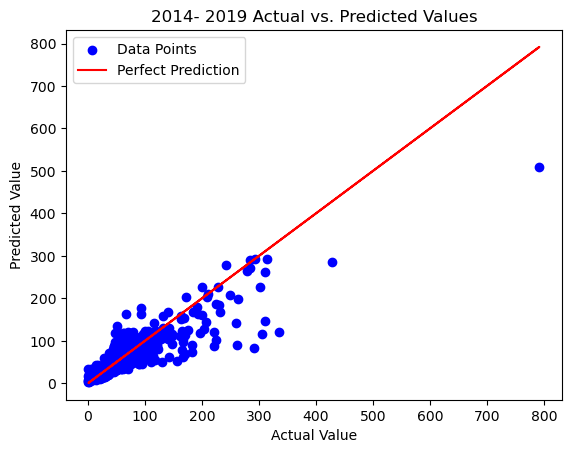

In [183]:
plt.scatter(rf_diff['Actual value'], rf_diff['Predicted value'], color='blue', label='Data Points')
plt.plot(rf_diff['Actual value'], rf_diff['Actual value'], color='red', label='Perfect Prediction')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('2014- 2019 Actual vs. Predicted Values')
plt.legend()
plt.show()

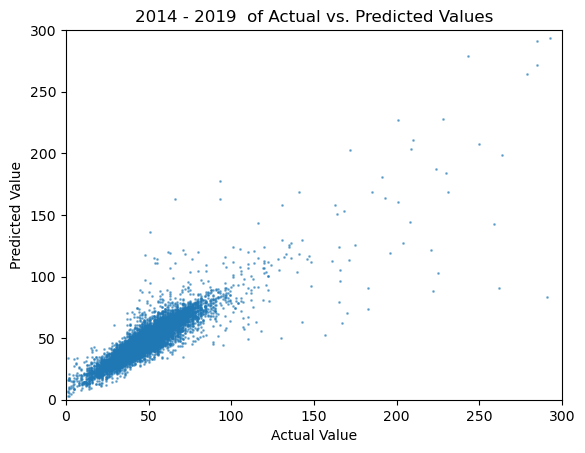

In [184]:
plt.scatter(rf_diff['Actual value'], rf_diff['Predicted value'],s=1, alpha=0.5)

# Add labels and title
x_min=0
x_max=300

y_min=0
y_max=300
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('2014 - 2019  of Actual vs. Predicted Values')

# Display the plot
plt.show()

## Random Forest Predicted vs Actual Value

In [187]:
rf_diff.head(100)

,Actual value,Predicted value
55339,59,59.08
36550,26,25.70
13935,37,37.94
23919,57,57.27
17877,46,46.32
...,...,...
28934,37,37.41
93532,33,40.56
44668,38,39.35
22147,40,42.77


## ANN model Prediction of 2014- 2019

In [93]:
from sklearn.metrics import accuracy_score

In [75]:
from keras.models import Sequential
from keras.layers import Dense,Dropout
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [76]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.optimizers import Adam
from tensorflow.keras.models import load_model

In [207]:
model_ann = Sequential()

#input layer 
model_ann.add(Dense(units=8, activation='relu', input_shape=(X_train.shape[1],)))
#hidden layer
model_ann.add(Dense(units=4, activation='relu'))
model_ann.add(Dense(units=4, activation='relu'))
#output layer
model_ann.add(Dense(units=1, activation='linear'))

# Compile the model
model_ann.compile(loss='mean_squared_error', optimizer='adam')

In [230]:
batch_size = 42
epochs = 60
model_ann.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.2)

Epoch 1/60
1591/1591 [==============================] - 5s 3ms/step - loss: 186.3090 - val_loss: 163.2855
Epoch 2/60
1591/1591 [==============================] - 5s 3ms/step - loss: 185.8161 - val_loss: 188.5331
Epoch 3/60
1591/1591 [==============================] - 5s 3ms/step - loss: 184.8153 - val_loss: 182.0907
Epoch 4/60
1591/1591 [==============================] - 5s 3ms/step - loss: 185.4939 - val_loss: 149.5207
Epoch 5/60
1591/1591 [==============================] - 5s 3ms/step - loss: 185.0607 - val_loss: 153.6825
Epoch 6/60
1591/1591 [==============================] - 5s 3ms/step - loss: 185.1876 - val_loss: 170.6703
Epoch 7/60
1591/1591 [==============================] - 5s 3ms/step - loss: 186.2571 - val_loss: 154.1691
Epoch 8/60
1591/1591 [==============================] - 5s 3ms/step - loss: 184.4963 - val_loss: 150.6319
Epoch 9/60
1591/1591 [==============================] - 5s 3ms/step - loss: 185.4422 - val_loss: 157.6927
Epoch 10/60
1591/1591 [=======================

In [213]:
y_pred_ann = model_ann.predict(X_test)

print("r2 score: %.10f" % r2_score(y_test, y_pred_ann))
print("explained variance score: %.10f" % explained_variance_score(y_test, y_pred_ann))
print("mae: %.10f" % mean_absolute_error(y_test, y_pred_ann))
print("mse: %.10f" % mean_squared_error(y_test, y_pred_ann))
print("rmse: %.10f" % mean_squared_error(y_test, y_pred_ann,squared = False))

653/653 [==============================] - 0s 584us/step
r2 score: 0.3153667084
explained variance score: 0.3258892426
mae: 7.8435377554
mse: 201.5462256349
rmse: 14.1966977018


In [214]:
mse_ann = mean_squared_error(y_test, y_pred)
mae_ann= mean_absolute_error(y_test, y_pred)
#mse_rf= mean_squared_error(y_test, y_pred_rf)
rmse_ann=mean_squared_error(y_test, y_pred,squared = False)

r2_ann = r2_score(y_test, y_pred_ann)

In [215]:
data_1d = y_pred_ann.reshape(-1)

In [224]:
ann_diff = pd.DataFrame({'Actual value': y_test, 'Predicted value': data_1d})

In [225]:
ann_diff

,Actual value,Predicted value
55339,59,57.437710
36550,26,35.174847
13935,37,40.386318
23919,57,49.405453
17877,46,51.006954
...,...,...
45182,52,44.191219
91653,59,55.146145
22918,41,47.913723
25584,48,41.888851


## Comparisom of Linear Regression, Random Forest and ANN result of MAE and RMSE

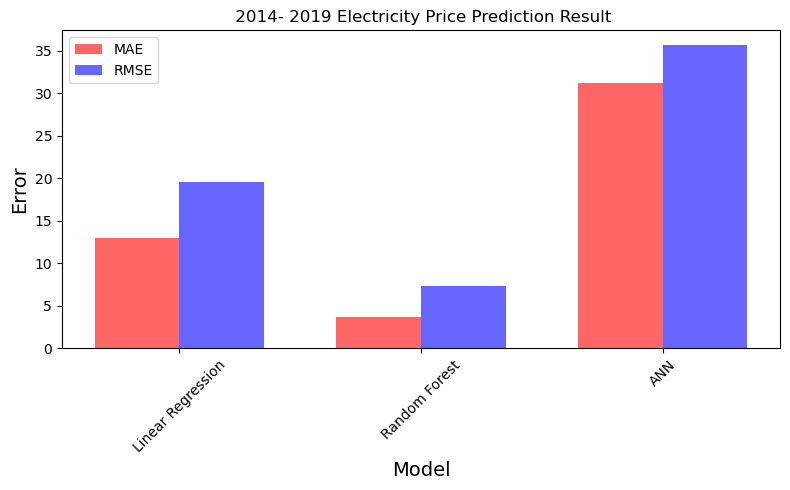

In [221]:
models = ['Linear Regression', 'Random Forest','ANN']
mae_values = [mae_lr, mae_rf, mae_ann]
rmse_values = [rmse_lr, rmse_rf, rmse_ann]
r2_values = [r2_lr, r2_rf, r2_ann]

bar_width = 0.35
index = np.arange(len(models))

plt.figure(figsize=(8, 5))
plt.bar(index, mae_values, width=bar_width, label='MAE', color='r', alpha=0.6)
plt.bar(index + bar_width, rmse_values, width=bar_width, label='RMSE', color='b', alpha=0.6)
#plt.bar(index +2* bar_width, r2_values, width=bar_width, label=' R2 Score', color='g', alpha=0.6)

plt.xlabel('Model', fontsize=14)
plt.ylabel('Error', fontsize=14)
plt.title(' 2014- 2019 Electricity Price Prediction Result', fontsize=12)
plt.xticks(index + bar_width/2, models, rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

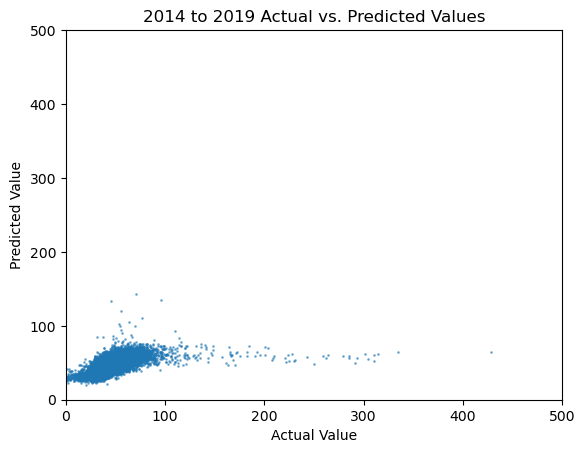

In [226]:
plt.scatter(ann_diff['Actual value'], ann_diff['Predicted value'],s=1, alpha=0.5)

# Add labels and title
x_min=0
x_max=500

y_min=0
y_max=500
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('2014 to 2019 Actual vs. Predicted Values')

# Display the plot
plt.show()

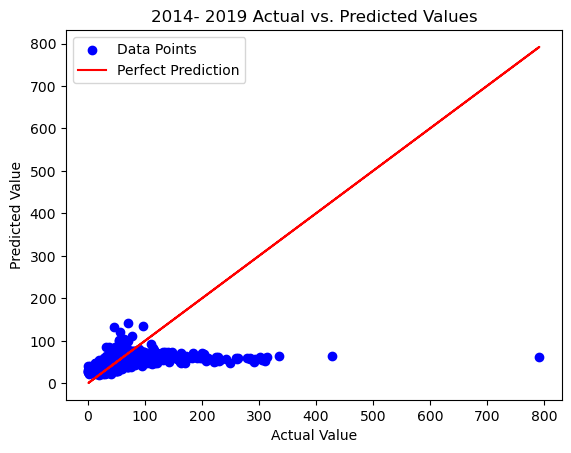

In [227]:
plt.scatter(ann_diff['Actual value'], ann_diff['Predicted value'], color='blue', label='Data Points')
plt.plot(ann_diff['Actual value'], ann_diff['Actual value'], color='red', label='Perfect Prediction')
plt.xlabel('Actual Value')
plt.ylabel('Predicted Value')
plt.title('2014- 2019 Actual vs. Predicted Values')
plt.legend()
plt.show()

## Linear Regression, Random Forest and ANN Predicted Result 2014-2019

In [229]:
print("ANN R-squared:", r2_ann)
print(" ANN R mean square error:", rmse_ann)
print("ANN Mean Squared Error:", mse_rf)
print(" Random forest R-squared:", r2_rf)
print("Random forest Mean Absoult Error:", mae_rf)
print(" Random forest r Mean Squared Error:", rmse_rf)
print("Linear Regression r2 score: %.10f" % r2_score(y_test, y_pred_mlr))

print(" Linear Regression mae : %.10f" % mean_absolute_error(y_test, y_pred_mlr))
print("Linear Regression mse: %.10f" % mean_squared_error(y_test, y_pred_mlr))
print("Linear Regression rmse: %.10f" % mean_squared_error(y_test, y_pred_mlr,squared = False))

ANN R-squared: 0.3153667084160987
 ANN R mean square error: 35.619110746735934
ANN Mean Squared Error: 54.456110732081264
 Random forest R-squared: 0.8150177894926023
Random forest Mean Absoult Error: 3.7195745496358756
 Random forest r Mean Squared Error: 7.3794383751123815
Linear Regression r2 score: -0.2997157691
 Linear Regression mae : 13.0109201097
Linear Regression mse: 382.6176887467
Linear Regression rmse: 19.5606157558
